# KD-CNN Class

In [12]:
# # import standard libraries
# from sklearn.mixture import GaussianMixture
# import tensorflow as tf
# tf.config.run_functions_eagerly(True)
# from tensorflow import keras
# from keras import layers
# from keras import Model
# from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
# import numpy as np
# from scipy.stats import multivariate_normal
# import warnings
# import matplotlib.pyplot as plt
# from sklearn.covariance import LedoitWolf
from sklearn.utils import shuffle

In [13]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
from tensorflow import keras

class kdcnn():
    def __init__(
        self,
        network,
        num_fc_layers,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.encoder = None
        self.num_fc_layers = num_fc_layers
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the CNN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each fully connected
        self.network_shape = []
        for layer_id in np.arange(self.total_layers-self.num_fc_layers, self.total_layers, 1):
            self.network_shape.append(self.network.layers[layer_id].output_shape[-1])

        # get the weights and biases of the trained fully connected layers
        self.weights = {}
        self.biases = {}
        k = 0
        for i in np.arange(self.total_layers-self.num_fc_layers, self.total_layers, 1):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[k], self.biases[k] = weight, bias.reshape(1, -1)
            k += 1

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in np.arange(self.total_layers-self.num_fc_layers, self.total_layers, 1):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")

    def unit_step(self, x):
        """Computes the unit step function output for a given input

        Parameters
        ----------
        x : ndarray
            Input array

        Returns
        -------
        ndarray
            Unit step function output of the input array
        """
        x = np.maximum(x, 0)
        x[x > 0] = 1
        return x

    def compute_weights(self, X_, polytope_id):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """
        
        M_ref = self._get_activation_pattern(polytope_id)

        start = 0
        A = X_
        A_ref = X_
        d = 0
        for l in range(len(self.network_shape)-1):
            end = start + self.network_shape[l]
            M_l = M_ref[start:end]
            start = end
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
            pre_A_ref = A_ref @ W + B
            A_ref = pre_A_ref @ np.diag(M_l) 
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)

        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        # X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        # get convolutional encoder outputs
        self.encoder = keras.Model(self.network.input, self.network.layers[-(self.num_fc_layers + 1)].output)
        X = self.encoder.predict(X)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                if self.weighting_method == "lin":
                    # compute weights of the input data samples w.r.t reference polytope
                    weights = self.compute_weights(X_, polytope_memberships[idx])
                elif self.weighting_method == "fm":
                    ########### FM (will be depricated) ################
                    a_native = self._get_activation_pattern(polytope_memberships[idx])
                    weights = []
                    for member_polytope_id in polytope_memberships:
                        a_foreign = self._get_activation_pattern(member_polytope_id)

                        match_status = a_foreign == a_native
                        match_status = match_status.astype("int")

                        if len(np.where(match_status == 0)[0]) == 0:
                            weight = 1.0
                        else:
                            first_mismatch_idx = np.where(match_status == 0)[0][0]
                            weight = first_mismatch_idx / self.num_fc_neurons

                        weights.append(weight)
                    weights = np.array(weights)
                ########### FM (will be depricated) ################
                else:
                    weights = np.zeros((X_.shape[0],))
                    weights[polytope_memberships == polytope_memberships[idx]] = 1

                weights[weights < 1e-3] = 0  # set very small weights to zero

                idx = np.where(weights > 0)[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                scales = weights[idx] / np.max(weights[idx])

                # apply weights to the data
                X_tmp = X_[idx].copy()
                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = self.encoder.predict(X)
        return np.argmax(self.predict_proba(X), axis=1)


#MNIST

In [14]:
## load data 
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [15]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [16]:
## normalize
x_train = x_train/255.0
x_test = x_test/255.0

In [17]:
## define network 

def getCNN():

  network_base = keras.Sequential()

  # conv blocks
  network_base.add(keras.layers.Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 1)))
  network_base.add(keras.layers.BatchNormalization())
  network_base.add(keras.layers.Activation('relu'))

  network_base.add(keras.layers.Conv2D(filters=4, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(keras.layers.BatchNormalization())
  network_base.add(keras.layers.Activation('relu'))

  network_base.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(keras.layers.BatchNormalization())
  network_base.add(keras.layers.Activation('relu'))

  network_base.add(keras.layers.Flatten())

  # fully-connected layers
  network_base.add(keras.layers.Dense(20, activation='relu'))
  network_base.add(keras.layers.Dense(20, activation='relu'))
  network_base.add(keras.layers.Dense(20, activation='relu'))
  network_base.add(keras.layers.Dense(10, activation='softmax'))

  network_base.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(3e-4))
  return network_base

## MNIST Experiments

In [18]:
network = getCNN()
network.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 2)         20        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 2)        8         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 2)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 4)         76        
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 4)        16        
 hNormalization)                                                 
                                        

2022-02-22 22:23:38.903058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 22:23:38.903778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
## train Vanilla-CNN
compile_kwargs = {
            "loss": "categorical_crossentropy",
            "optimizer": keras.optimizers.Adam(3e-4)
            }
fit_kwargs = {
    "epochs": 10,
    "batch_size": 256,
    "verbose": True
    }
network.compile(**compile_kwargs)
network.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)

2022-02-22 22:23:42.196533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-02-22 22:23:42.474990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 7s 18ms/step - loss: 1.6100
Epoch 2/10
235/235 [==============================] - 3s 13ms/step - loss: 0.5655
Epoch 3/10
235/235 [==============================] - 3s 13ms/step - loss: 0.3502
Epoch 4/10
235/235 [==============================] - 3s 13ms/step - loss: 0.2564
Epoch 5/10
235/235 [==============================] - 3s 13ms/step - loss: 0.2018
Epoch 6/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1685
Epoch 7/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1467
Epoch 8/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1308
Epoch 9/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1198
Epoch 10/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1105


In [20]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
X, y = x_train[:5000], y_train[:5000]
Xt, yt = x_test[:1000], y_test[:1000]

In [21]:
## train KD-CNN
model_kdn = kdcnn(
    network=network,
    num_fc_layers=3, 
    polytope_compute_method='all',
    weighting_method='lin',
    k=1e-5,
    c=1, 
    verbose=False
)
model_kdn.fit(X, y)

2022-02-22 22:24:16.591992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [22]:
## Evaluate KD-CNN
y_pred = model_kdn.predict(Xt)
accuracy = np.mean(y_pred==yt.squeeze())
print("Accuracy : {}".format(accuracy))

Accuracy : 0.971


In [23]:
## Evaluate Vanilla CNN
proba_nn = network.predict(Xt)
predicted_label = np.argmax(proba_nn, axis=1)
accuracy = np.mean(predicted_label==yt.squeeze())
print("Accuracy : {}".format(accuracy))

Accuracy : 0.97


2022-02-22 22:24:32.040290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Adversarial Experiment

In [24]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [25]:
# generate adversarial samples
Xta = np.empty((0, 28, 28, 1))
for i in range(1000):
  im = Xt[i].squeeze()
  im = np.ravel(im)
  im = np.random.permutation(im)
  im = np.reshape(im, (28, 28))
  im = gaussian_filter(im, 1.5)
  im /= np.max(im)
  Xta = np.vstack((Xta, im.reshape(1, 28, 28, 1)))

In [26]:
## Evaluate KD-CNN
proba_kdn = model_kdn.predict_proba(model_kdn.encoder.predict(Xta))
MMC = np.mean(np.max(proba_kdn, axis=1))
print(MMC)

0.10000225520561393


In [28]:
proba_kdn[0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [27]:
## Evaluate Vanilla CNN
proba_nn = network.predict(Xta)
MMC = np.mean(np.max(proba_nn, axis=1))
print(MMC)

0.6445841


# CIFAR-10




In [ ]:
## load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
## normalize
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
## define network 

def getCNN():

  network_base = keras.Sequential()

  # conv blocks
  network_base.add(layers.Conv2D(filters=4, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Flatten())

  # fully-connected layers
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(10, activation='softmax'))

  network_base.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(3e-4))
  return network_base

## CIFAR-10 Experiments

In [ ]:
network = getCNN()
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 4)         112       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 4)         16        
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 8)         296       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 8)         32        
_________________________________________________________________
activation_11 (Activation)   (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)         

In [ ]:
## train Vanilla-CNN
compile_kwargs = {
            "loss": "categorical_crossentropy",
            "optimizer": keras.optimizers.Adam(3e-4)
            }
fit_kwargs = {
    "epochs": 10,
    "batch_size": 256,
    "verbose": True
    }
network.compile(**compile_kwargs)
network.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
196/196 [==============================] - 9s 44ms/step - loss: 2.1152
Epoch 2/10
196/196 [==============================] - 9s 44ms/step - loss: 1.8548
Epoch 3/10
196/196 [==============================] - 9s 45ms/step - loss: 1.6764
Epoch 4/10
196/196 [==============================] - 9s 44ms/step - loss: 1.5587
Epoch 5/10
196/196 [==============================] - 9s 44ms/step - loss: 1.4784
Epoch 6/10
196/196 [==============================] - 9s 44ms/step - loss: 1.4166
Epoch 7/10
196/196 [==============================] - 9s 44ms/step - loss: 1.3660
Epoch 8/10
196/196 [==============================] - 9s 44ms/step - loss: 1.3216
Epoch 9/10
196/196 [==============================] - 9s 45ms/step - loss: 1.2849
Epoch 10/10
196/196 [==============================] - 9s 44ms/step - loss: 1.2538


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


label :  0
Number of Polytopes :  5000
Number of Unique Polytopes :  3640


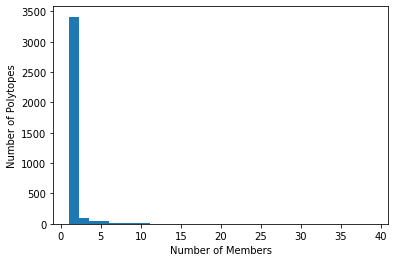

label :  1
Number of Polytopes :  5000
Number of Unique Polytopes :  4187


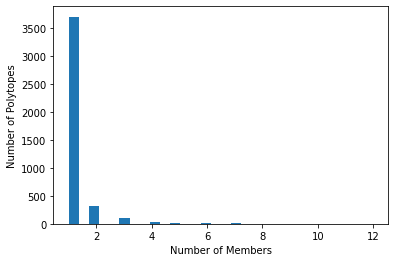

label :  2
Number of Polytopes :  5000
Number of Unique Polytopes :  3427


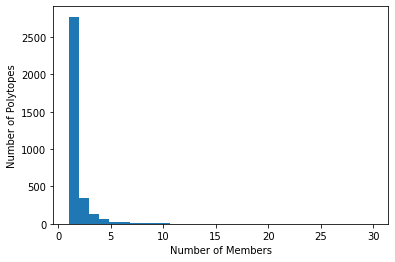

label :  3
Number of Polytopes :  5000
Number of Unique Polytopes :  2886


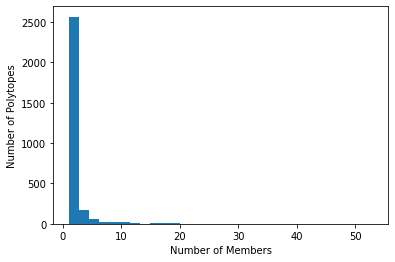

label :  4
Number of Polytopes :  5000
Number of Unique Polytopes :  3506


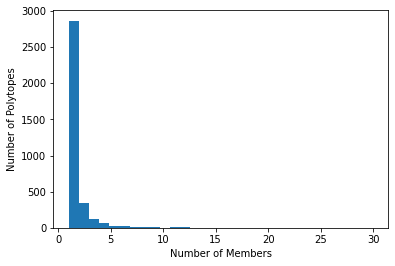

label :  5
Number of Polytopes :  5000
Number of Unique Polytopes :  2773


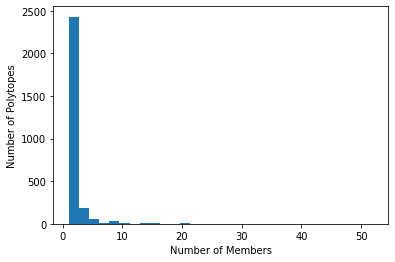

label :  6
Number of Polytopes :  5000
Number of Unique Polytopes :  3434


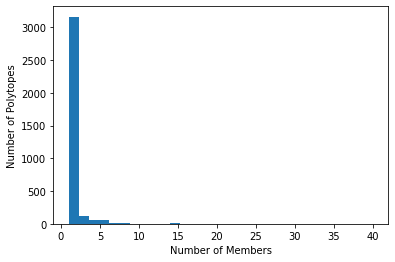

label :  7
Number of Polytopes :  5000
Number of Unique Polytopes :  3227


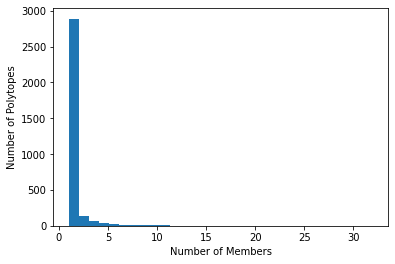

label :  8
Number of Polytopes :  5000
Number of Unique Polytopes :  3234


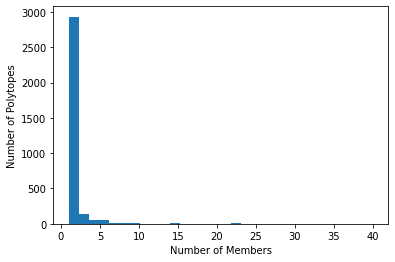

label :  9
Number of Polytopes :  5000
Number of Unique Polytopes :  3652


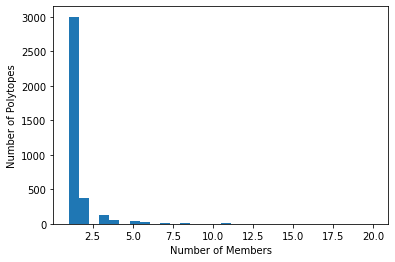

In [ ]:
model_kdn = kdcnn(network=network, num_fc_layers=4)
model_kdn.fit(x_train, y_train)

In [ ]:
## Evaluate KD-CNN
y_pred = model_kdn.predict(x_test)
accuracy = np.mean(y_pred==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy : 0.5217


In [ ]:
## Evaluate Vanilla CNN
proba_nn = model_kdn.network.predict(x_test)
predicted_label = np.argmax(proba_nn, axis=1)
accuracy = np.mean(predicted_label==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy : 0.5311
